In [1]:
import sys; sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from simulator import ContextualWebServer, BanditSimulator
from policy import LinThompsonSampling, LinUCB, LogisticThompsonSampling
from ope_estimator import ReplayMethod

In [2]:
n_action=30
dim_user_context=10
dim_context=10
reward_type="binary"
noise_ver=1.

In [3]:
web_server = ContextualWebServer(
    n_action=n_action,
    dim_user_context=dim_user_context,
    dim_context=dim_context,
    reward_type=reward_type,
    noise_ver=noise_ver
)

In [4]:
n_round=1000
batch_size=1

In [5]:
# generate bandit data for ReplayMethod
simulator = BanditSimulator(
    T=n_round,
    batch_size=batch_size,
    n_action=n_action
)
simulator.run(policy="Random", web_server=web_server)
bandit_data = simulator.observed_data

In [6]:
bandit_data["reward"].mean()

0.506

In [7]:
noise_zero_ver=1.0
alpha=0.1

In [8]:
# LinUCB
noise_zero_ver=1.0
alpha=5

lin_ucb = LinUCB(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
    alpha=alpha,
)

# LinTS
lin_ts = LinThompsonSampling(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
)

# LogisticTS
n_epoch=10

logistic_ts = LogisticThompsonSampling(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
    n_epoch=n_epoch,
)

policies = {"LinUCB": lin_ucb, "LinTS": lin_ts, "LogisticTS": logistic_ts}

In [9]:
# Replay Method

pi_new_estimated_rewards = dict()
for policy_name, policy in policies.items():

    rm = ReplayMethod(n_action=n_action, policy=policy)
    estimated_value = rm.estimate(contexts=bandit_data["context"], actions=bandit_data["action"], rewards=bandit_data["reward"])
    pi_new_estimated_rewards[policy_name] = estimated_value

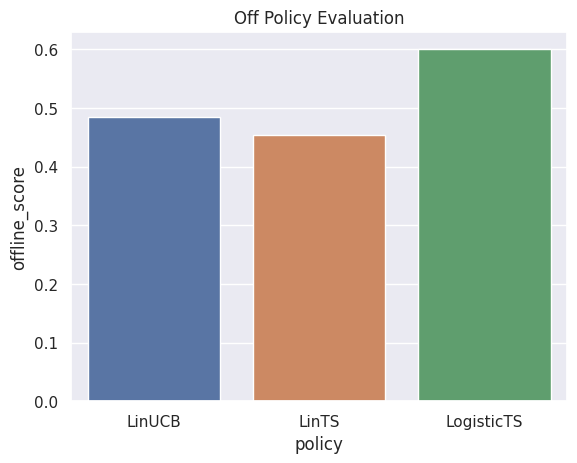

In [10]:
df = pd.DataFrame(list(pi_new_estimated_rewards.items()), columns=['policy', 'offline_score'])

sns.barplot(x="policy", y='offline_score', data=df)
plt.title('Off Policy Evaluation')
plt.show()

In [11]:
# ground truth
pi_new_online_rewards = dict()
for policy_name, policy in policies.items():
    simulator.run(policy=policy, web_server=web_server)
    pi_new_online_rewards[policy_name] = simulator.observed_data["reward"].mean()

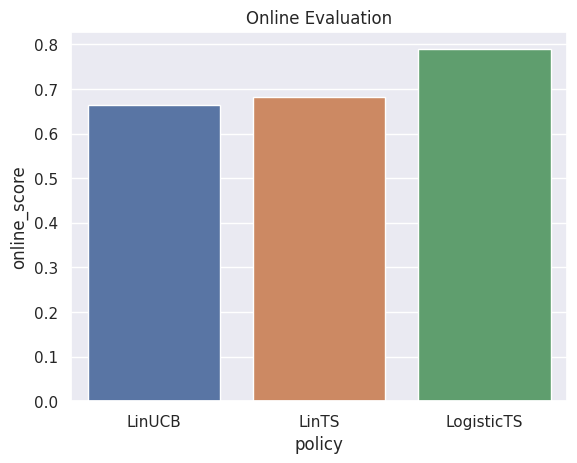

In [12]:
df["online_score"] = pi_new_online_rewards.values()
sns.barplot(x="policy", y='online_score', data=df)
plt.title('Online Evaluation')
plt.show()

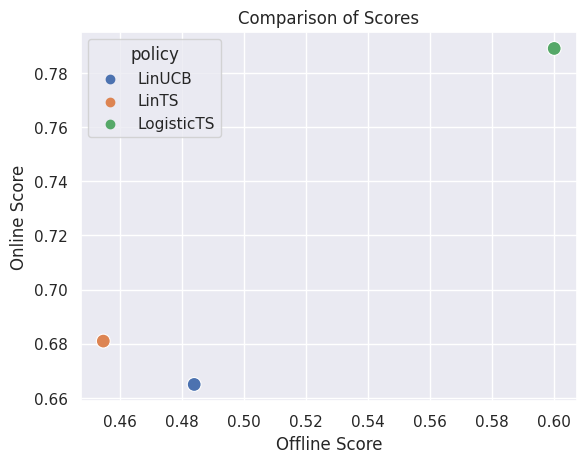

In [14]:
sns.scatterplot(x='offline_score', y='online_score', hue='policy', data=df, s=100)

plt.title('Comparison of Scores')
plt.xlabel('Offline Score')
plt.ylabel('Online Score')

plt.legend(title='policy')

plt.show()